# Reddit Datasets

## Using [Pushshift](https://github.com/pushshift/api) to download Reddit data

There are currently a couple Reddit datasets available to download:

### Headline mentions
* `reddit_headline_counts.csv`: Contains how many times a candidate's name was mentioned in a /r/politics, /r/news, or /r/worldnews post from January 1, 2019 to June 2019.

### Article Text Parsing
* `reddit_2016_05_31.pkl`: Contains the post id, number of comments, karma score, subreddit, number of subscribers in that subreddit, title of post link, and url of article links posted to /r/politics and a couple of the specific Republican candidates' subreddits from January 1, 2015 to May 31, 2016 (Trump won delegate majority in late May 2016).
* `reddit_2019_06_15.pkl`: Contains the post id, number of comments, karma score, subreddit, number of subscribers in that subreddit, title of post link, and url of article links posted to /r/politics and a couple of the specific Democratic candidates; subreddits from January 1, 2019 to June 15, 2019

(Those three files above can be found at https://berkeley-politics-capstone.s3.amazonaws.com/reddit.zip)

* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2019jun16tojul1_articleurls.pkl : This is a dataframe, from **June 16, 2019 to July 1, 2019** to append onto `reddit_2019_06_15.pkl`

### Article Text Parsing Supplements
* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2016_dates.pkl : Used with the 2016 Article Text Parsing data to grab the dates of the article from Reddit
* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2019_dates.pkl : Used with the 2019 Article Text Parsing data to grab the dates of the article from Reddit
* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2019jun16tojul1_dates.pkl : This is a dataframe, from **June 16, 2019 to July 1, 2019** to append onto the URL above

### Reddit uncleaned comments

* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2016_comments.pkl : Comments left in subreddits that were gathered from `reddit_2016_05_31.pkl` (/r/politics and the subreddits for certain Republican candidates)

* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2019_comments.pkl : Comments left in subreddits that were gathered from `reddit_2019_06_15.pkl` (/r/politics and the subreddits for certain Democratic candidates)

* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2019jun16tojul1_comments.pkl : This is a dataframe, from **June 16, 2019 to July 1, 2019** to append onto the URL above

### Reddit cleaned comments

* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2016_comments_clean1.pkl : 2016 comments that have their markdown formatting stripped
* https://berkeley-politics-capstone.s3.amazonaws.com/reddit_2019_comments_clean1.pkl : 2019 (Jan 1 to Jul 1) comments that have their markdown formatting stripped

### How to use the data

* Within the data folder, make a new folder called Reddit and place the files in there.
* The pickled files are pandas data frames when unpickled, so use the following command: `df = pd.read_pickle(file)`

In [1]:
# Libraries

import requests
import praw
import praw.models
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import json
import os
import html
from bs4 import BeautifulSoup
from markdown import markdown
from datetime import datetime, timedelta, date
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

/Users/kanithamann/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Pushshift API - a free API with no credentials needed

Pushshift API is more useful to gather aggregate data of a metric in a subreddit, such as number of times a query is mentioned, or to gather a field that meets certain conditions. Additionally, Pushshift is free to use and does not require any credentials.

See https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/ for more helpful information.

### List of URLs

Most of the time in /r/politics, users submit link posts to articles. We'd like to gather a list of these articles so that we may use the `news-please` library to grab the text and subsequently do NLP on it. To get this list, I've used Pushshift and used the following call: 

https://api.pushshift.io/reddit/submission/search/?subreddit=politics&after=2019-06-01&before=2019-06-10&is_self=false&filter=title,subreddit,url,score,num_comments,subreddit_subscribers,id&limit=1000

Note about subreddits: Michael Bennet, Steve Bullock, Julián Castro, Bill de Blasio, John Delaney, John Hickenlooper, Seth Moulton, Tim Ryan, Eric Swalwell, Marianne Williamson, and Andrew Yang are candidates who do not have dedicated subreddits as of May 30, 2019.

In [2]:
# Initial step: Creating the list

output = pd.DataFrame(columns=['id','num_comments','score','subreddit','subreddit_subscribers','title','url'])

In [3]:
# Set the date range

start_date = date(2019, 6, 16)

day_count = (date(2019, 7, 1) - start_date).days + 1 # The last time I pulled the 2019 dataset together

#day_count = (date(2016, 5, 31) - start_date).days + 1 # For use with the 2015 dataset


# Set the subreddits to go through

subreddits = {'Joe Biden': 'JoeBiden',
              'Cory Booker': 'corybooker',
              'Pete Buttigieg': 'Pete_Buttigieg',
              'Tulsi Gabbard': 'tulsi',
              'Kirsten Gillibrand': 'Kirsten_Gillibrand',
              'Mike Gravel': 'gravelforpresident',
              'Kamala Harris': 'Kamala',
              'Jay Inslee': 'inslee2020',
              'Amy Klobuchar': 'BaemyKlobaechar',
              'Beto O\'Rourke': 'Beto2020',
              'Bernie Sanders': 'SandersForPresident',
              'Donald Trump': 'The_Donald',
              'Elizabeth Warren': 'ElizabethWarren',
             'politics': 'politics'}

# Subreddits for 2016 candidates

subreddits_2016 = {'Donald Trump': 'The_Donald',
                   'Ted Cruz': 'TedCruz',
                   'Jeb Bush': 'JebBush',
                   'Ben Carson': 'BenCarson',
                   'Chris Christie': 'ChrisChristie',
                   'Jon Kasich': 'KasichForPresident',
                   'Rand Paul': 'RandPaul',
                   'Marco Rubio': 'Marco_Rubio',
                   'politics': 'politics'}

# For loop that iterates through the day to get 1000 link posts, then scrapes some choice domains away

for single_date in (start_date + timedelta(n) for n in range(day_count)):
    
    after = single_date.strftime("%Y-%m-%d")
    before = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
    for subreddit in subreddits.values():
    
        url = 'https://api.pushshift.io/reddit/submission/search/?subreddit={0}&after={1}&before={2}&is_self=false&filter=id,title,subreddit,url,score,num_comments,subreddit_subscribers&limit=1000'.format(subreddit,after,before)

        r = requests.get(url)
        
        if r.status_code != 200:
            continue
            
        else:
            response = r.json()
        
            if bool(response['data']):
                temp = pd.DataFrame.from_dict(response['data'], orient='columns')
                output = output.append(temp, ignore_index = True)


In [4]:
# Remove non article URLs

remove = ['twitter.com','hbo.com','youtube.com','youtu.be','reddit.com','streamable.com','imgur.com',
                         'i.imgur.com','forgifs.com','i.redd.it']
searchrm = '|'.join(remove)

output = output[~output['url'].str.contains(searchrm)].reset_index(drop=True)

In [5]:
# Pickling the dataframe

output.to_pickle('reddit_2019jun16tojul1.pkl')

## Getting the dates of a post

News Please has an issue with generating dates to the articles, so we have opted to use Reddit's post datetime instead. This will be done Pushshift again; the code below is the refactored version of what is above (I originally tried PRAW but it was too slow to feed in a post ID one by one).

In [6]:
# Instantiate the date dataframe
dates = pd.DataFrame(columns=['created_utc','id','url'])

In [7]:
# Set the date range

start_date = date(2019, 6, 16)

day_count = (date(2019, 7, 1) - start_date).days + 1 # The last time I pulled the 2019 dataset together

#day_count = (date(2016, 5, 31) - start_date).days + 1 # For use with the 2015 dataset


# Set the subreddits to go through

subreddits = {'Joe Biden': 'JoeBiden',
              'Cory Booker': 'corybooker',
              'Pete Buttigieg': 'Pete_Buttigieg',
              'Tulsi Gabbard': 'tulsi',
              'Kirsten Gillibrand': 'Kirsten_Gillibrand',
              'Mike Gravel': 'gravelforpresident',
              'Kamala Harris': 'Kamala',
              'Jay Inslee': 'inslee2020',
              'Amy Klobuchar': 'BaemyKlobaechar',
              'Beto O\'Rourke': 'Beto2020',
              'Bernie Sanders': 'SandersForPresident',
              'Donald Trump': 'The_Donald',
              'Elizabeth Warren': 'ElizabethWarren',
             'politics': 'politics'}

# Subreddits for 2016 candidates

subreddits_2016 = {'Donald Trump': 'The_Donald',
                   'Ted Cruz': 'TedCruz',
                   'Jeb Bush': 'JebBush',
                   'Ben Carson': 'BenCarson',
                   'Chris Christie': 'ChrisChristie',
                   'Jon Kasich': 'KasichForPresident',
                   'Rand Paul': 'RandPaul',
                   'Marco Rubio': 'Marco_Rubio',
                   'politics': 'politics'}

# For loop that iterates through the day to get 1000 link posts, then scrapes some choice domains away

for single_date in (start_date + timedelta(n) for n in range(day_count)):
    
    after = single_date.strftime("%Y-%m-%d")
    before = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
    for subreddit in subreddits.values():
    
        url = 'https://api.pushshift.io/reddit/submission/search/?subreddit={0}&after={1}&before={2}&is_self=false&filter=id,created_utc,url&limit=1000'.format(subreddit,after,before)

        r = requests.get(url)
        
        if r.status_code != 200:
            continue
            
        else:
            response = r.json()
        
            if bool(response['data']):
                temp = pd.DataFrame.from_dict(response['data'], orient='columns')
                dates = dates.append(temp, ignore_index = True)


In [8]:
# Remove non article URLs

remove = ['twitter.com','hbo.com','youtube.com','youtu.be','reddit.com','streamable.com','imgur.com',
                         'i.imgur.com','forgifs.com','i.redd.it']
searchrm = '|'.join(remove)

dates = dates[~dates['url'].str.contains(searchrm)].reset_index(drop=True)

In [9]:
# Now remove the URL column, and convert the date column into datetime
dates = dates.drop("url", axis=1)
dates['created_utc'] = dates['created_utc'].apply(lambda x: datetime.utcfromtimestamp(x))

In [10]:
dates

,created_utc,id
0,2019-06-16 14:07:43,c1a95h
1,2019-06-16 15:03:55,c1aut2
2,2019-06-16 20:37:44,c1emsd
3,2019-06-16 00:17:09,c14017
4,2019-06-16 01:17:27,c14jyo
5,2019-06-16 01:28:04,c14nd1
6,2019-06-16 01:41:41,c14rh6
7,2019-06-16 02:16:37,c152af
8,2019-06-16 07:27:26,c17en0
9,2019-06-16 11:33:06,c18ynu


In [11]:
# Pickling the dataframe

dates.to_pickle('reddit_2019jun16tojul1_dates.pkl')

## Logistic Regression

Will be switching over to Pushshift API for this process, which allows us to get data between dates

Example call: https://api.pushshift.io/reddit/submission/search/?after=2019-06-02&before=2019-06-03&q=trump&sort_type=score&sort=desc&subreddit=politics&limit=500

Where the output is a JSON file, the after date is the date of interest, and the before date is one date in the future.

### Headline mentions vs donations
#### Consider calculating the cumulative karma score and comments along with this later on

The Pushshift API call used here will rely on `agg=subreddit` to get counts and will look like the following:

https://api.pushshift.io/reddit/submission/search/?subreddit=politics,news,worldnews&aggs=subreddit&q=trump&size=0&after=2019-06-02&before=2019-06-03

This data will be stored in a csv file that can be pulled in later: `mentions = pd.read_csv('reddit_headline_counts.csv')`

In [ ]:
politicians = ['williamson', 'harris', 'buttigieg', 'klobuchar', 'yang', 'gillibrand', 'delaney', 'inslee', 
               'hickenlooper', 'o\%27rourke', 'warren', 'castro', 'sanders', 'gabbard', 'booker', 'trump', 'biden']

# Set the date range

start_date = date(2019, 3, 8)

day_count = (date(2019, 3, 14) - start_date).days + 1

# Set the rows_list holder
rows_list = []

# For loop that iterates through the day to get 1000 link posts, then scrapes some choice domains away

for single_date in (start_date + timedelta(n) for n in range(day_count)):
    
    after = single_date.strftime("%Y-%m-%d")
    before = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
    for candidate in politicians:
        url = 'https://api.pushshift.io/reddit/submission/search/?subreddit=politics,news,worldnews&aggs=subreddit&q={0}&size=0&after={1}&before={2}'.format(candidate,after,before)
        response = requests.get(url).json()
        
        for thing in response['aggs']['subreddit']:
            dict1 = {}
            dict1.update({'date': after, 
                          'candidate': candidate, 
                          'subreddit': thing['key'], 
                          'doc_count': thing['doc_count']})
            rows_list.append(dict1)
            
mentions = pd.DataFrame(rows_list)

In [99]:
#mentions

#mentions.to_csv('mar8tomar14.csv',index=False)

# To reload, use:
mentions = pd.read_csv('../../data/reddit/reddit_headline_counts.csv')

In [104]:
# O'Rourke candidate name change

mentions = mentions.replace('o\%27rourke', 'orourke')
by_politics = mentions[mentions['subreddit']=='politics']

In [106]:
# From Andrew:
# find the path to each fec file, store paths in a nested dict
fec_2020_paths = {}
base_path = os.path.join("..","..","data","fec","2020") # This notebook was one more level down
for party_dir in os.listdir(base_path):
    if(party_dir[0]!="."):
        fec_2020_paths[party_dir] = {}
        for cand_dir in os.listdir(os.path.join(base_path,party_dir)):
            if(cand_dir[0]!="."):
                fec_2020_paths[party_dir][cand_dir] = {}
                for csv_path in os.listdir(os.path.join(base_path,party_dir,cand_dir)):
                    if(csv_path.find("schedule_a")>=0):
                        fec_2020_paths[party_dir][cand_dir]["donations"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
                    elif(csv_path.find("schedule_b")>=0):
                        fec_2020_paths[party_dir][cand_dir]["spending"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
print(json.dumps(fec_2020_paths, indent=4))

{
    "republican": {
        "trump": {
            "spending": "../../data/fec/2020/republican/trump/schedule_b-2019-05-30T16_03_37.csv",
            "donations": "../../data/fec/2020/republican/trump/schedule_a-2019-05-30T16_03_37.csv"
        }
    },
    "democrat": {
        "williamson": {
            "spending": "../../data/fec/2020/democrat/williamson/schedule_b-2019-05-30T20_41_44.csv",
            "donations": "../../data/fec/2020/democrat/williamson/schedule_a-2019-05-30T20_41_32.csv"
        },
        "harris": {
            "spending": "../../data/fec/2020/democrat/harris/schedule_b-2019-05-30T17_22_09.csv",
            "donations": "../../data/fec/2020/democrat/harris/schedule_a-2019-05-30T17_19_58.csv"
        },
        "buttigieg": {
            "donations": "../../data/fec/2020/democrat/buttigieg/schedule_a-2019-05-30T17_32_11.csv",
            "spending": "../../data/fec/2020/democrat/buttigieg/schedule_b-2019-05-30T17_32_14.csv"
        },
        "klobuchar": {
 

In [132]:
dataset = pd.DataFrame()
for candid in fec_2020_paths["democrat"].keys():
    if("donations" in fec_2020_paths["democrat"][candid].keys()):
        
        # process donations dataset
        df1 = pd.read_csv(fec_2020_paths["democrat"][candid]["donations"])
        df1["contribution_receipt_date"] = pd.to_datetime(df1["contribution_receipt_date"]).dt.date
        df1 = df1.loc[df1["entity_type"]=="IND"]
        df1 = df1.loc[df1["contribution_receipt_amount"]<=2800]
        df1 = df1.groupby(by="contribution_receipt_date", as_index=False)["contribution_receipt_amount"].sum()
        df1.name = "individual_donations"
        df1 = pd.DataFrame(df1)
        df1["candidate"] = candid
        
        # attaching to the mentions dataset
        #result = mentions.merge(df1, how='inner', left_on=['', 'B'])

        
        # append to main df
        dataset = dataset.append(df1)

/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35,36,37,38,39,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35,36,37,38,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35) have mixed types. Specify dtype option on

In [136]:
dataset.rename(index=str, columns={'contribution_receipt_date':'date'}, inplace=True)

res = pd.merge(by_politics, dataset,  how='outer', left_on=['date','candidate'], 
                  right_on = ['date','candidate'])

res

,candidate,date,doc_count,subreddit,contribution_receipt_amount
0,harris,2019-01-01,1.0,politics,NaN
1,orourke,2019-01-01,1.0,politics,NaN
2,warren,2019-01-01,19.0,politics,NaN
3,sanders,2019-01-01,8.0,politics,NaN
4,gabbard,2019-01-01,1.0,politics,NaN
5,trump,2019-01-01,154.0,politics,NaN
6,biden,2019-01-01,2.0,politics,NaN
7,harris,2019-01-02,2.0,politics,NaN
8,klobuchar,2019-01-02,4.0,politics,NaN
9,inslee,2019-01-02,5.0,politics,NaN


In [142]:
# Replace NaN with 0

res['contribution_receipt_amount'].fillna(0, inplace = True) 
res['doc_count'].fillna(0, inplace = True) 
res

,candidate,date,doc_count,subreddit,contribution_receipt_amount
0,harris,2019-01-01,1.0,politics,0.00
1,orourke,2019-01-01,1.0,politics,0.00
2,warren,2019-01-01,19.0,politics,0.00
3,sanders,2019-01-01,8.0,politics,0.00
4,gabbard,2019-01-01,1.0,politics,0.00
5,trump,2019-01-01,154.0,politics,0.00
6,biden,2019-01-01,2.0,politics,0.00
7,harris,2019-01-02,2.0,politics,0.00
8,klobuchar,2019-01-02,4.0,politics,0.00
9,inslee,2019-01-02,5.0,politics,0.00


In [147]:
X_train = res["doc_count"].reshape(-1, 1)
y_train = res["contribution_receipt_amount"]
X_test = np.array(range(0,400)).reshape(-1, 1)
linear_fit = LinearRegression().fit(X_train, y_train)
y_pred = linear_fit.predict(X_test)

/Users/kanithamann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [148]:
linear_fit.score(X_train,y_train)

0.0035773008004679197

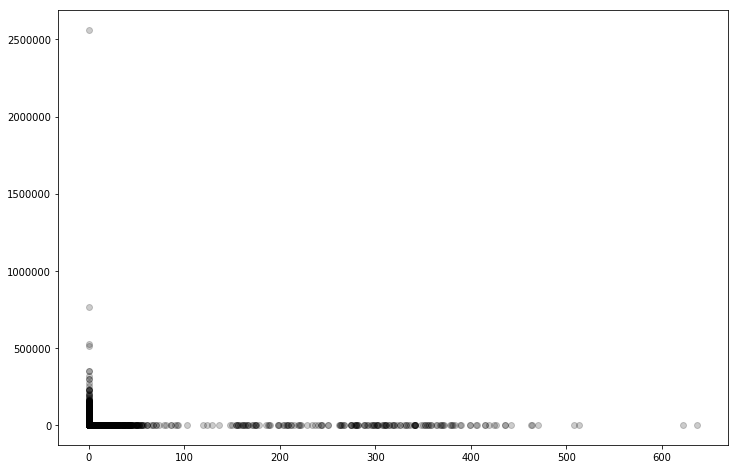

In [154]:
fix, ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train, y_train,  color='black', alpha=0.2)
#plt.plot(X_test, y_pred, color='blue', linewidth=3)

If we want an aggregate of comments and score for this particular dataset later, I've been playing around with the following Pushshift API call: https://api.pushshift.io/reddit/submission/search/?subreddit=politics,news,worldnews&aggs=subreddit&q=trump&after=2019-06-02&before=2019-06-03&filter=subreddit,score,num_comments

## Gathering comments from the subreddits above

In [12]:
comments = pd.DataFrame(columns=['body','created_utc','parent_id','score'])

In [13]:
# Set the date range

start_date = date(2019, 6, 16)

day_count = (date(2019, 7, 1) - start_date).days + 1 # The last time I pulled the 2019 dataset together

#day_count = (date(2016, 5, 31) - start_date).days + 1 # For use with the 2015 dataset


# Set the subreddits to go through

subreddits = {'Joe Biden': 'JoeBiden',
              'Cory Booker': 'corybooker',
              'Pete Buttigieg': 'Pete_Buttigieg',
              'Tulsi Gabbard': 'tulsi',
              'Kirsten Gillibrand': 'Kirsten_Gillibrand',
              'Mike Gravel': 'gravelforpresident',
              'Kamala Harris': 'Kamala',
              'Jay Inslee': 'inslee2020',
              'Amy Klobuchar': 'BaemyKlobaechar',
              'Beto O\'Rourke': 'Beto2020',
              'Bernie Sanders': 'SandersForPresident',
              'Donald Trump': 'The_Donald',
              'Elizabeth Warren': 'ElizabethWarren',
             'politics': 'politics'}

# Subreddits for 2016 candidates

subreddits_2016 = {'Donald Trump': 'The_Donald',
                   'Ted Cruz': 'TedCruz',
                   'Jeb Bush': 'JebBush',
                   'Ben Carson': 'BenCarson',
                   'Chris Christie': 'ChrisChristie',
                   'Jon Kasich': 'KasichForPresident',
                   'Rand Paul': 'RandPaul',
                   'Marco Rubio': 'Marco_Rubio',
                   'politics': 'politics'}

# For loop that iterates through the day to get 1000 link posts, then scrapes some choice domains away

for single_date in (start_date + timedelta(n) for n in range(day_count)):
    
    after = single_date.strftime("%Y-%m-%d")
    before = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
    for subreddit in subreddits.values():
    
        url = 'https://api.pushshift.io/reddit/search/comment/?subreddit={0}&after={1}&before={2}&limit=1000&sort=desc&sort_type=score&filter=parent_id,score,body,created_utc'.format(subreddit,after,before)

        r = requests.get(url)
        
        if r.status_code != 200:
            continue
            
        else:
            response = r.json()
            
        temp = pd.DataFrame.from_dict(response['data'], orient='columns')
        comments = comments.append(temp, ignore_index = True)
            
        


In [14]:
# Cleaning up the dataframe by removing [removed], and converting created_utc to a date time

#temp = temp[temp['parent_id'].str.startswith('t3')]

comments = comments[~comments['body'].str.startswith('[deleted]')]
comments['created_utc'] = comments['created_utc'].apply(lambda x:
                                                        datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

comments

,body,created_utc,parent_id,score
0,"Bernie is tanking, yes Lord!",2019-06-16,t3_c1a95h,23
1,It's nice to see Warren surpassing Bernie: she...,2019-06-16,t3_c1a95h,15
2,"Oh they will, and they will also cry about the...",2019-06-16,t1_erbwkgg,13
3,So worried the Bernie or Bust bros will once a...,2019-06-16,t1_erbw22d,12
4,Bernie sander and some Russian bots,2019-06-16,t3_c0kdy7,8
5,I’d be thrilled with either Warren or Harris.,2019-06-16,t1_erbwzua,7
6,"And? This is the primary election, the general...",2019-06-16,t1_erbz1us,7
7,The state of the democratic primary has remain...,2019-06-16,t3_c1aut2,7
8,The sad part to me is this. I think that Biden...,2019-06-16,t3_c1a95h,7
9,I dunno. I think that people have gotten it in...,2019-06-16,t3_c0kdy7,7


In [15]:
# Pickling

comments.to_pickle('reddit_2019jun16tojul1_comments.pkl')

# NLP

By day, we can gather:

1. What the sentiment of all post titles (by subreddit, and by if the candidate was mentioned in the title)
2. What the sentiment of the top 10 comments of each post is (by subreddit, and by if the candidate was mentioned in thetitle)
3. How many posts in the subreddit or if the candidate was mentioned in the title are (more of a general feature, not NLP)

* Day of post
* Post ID
* Headline
* Subreddit
* Entity recognition (candidates addressed in headline, binary as 1 or 0)
* Topic recognition (This may be difficult to grab from a headline, but could try in the comments)
* Sentiment of headline
* Sentiment of comments

## Cleaning of comments

The Reddit comment dataset consists of the following:

* body: Text itself
* created_utc: Date of the comment
* parent_id: The ID of the comment. **If the ID starts with t3, then it is a top-level comment, with the remainder alphanumeric characters indicating the post ID**
* score: Karma score of the comment

In [29]:
# Let's begin by unpickling

# For 2019, I had to combine dataframes

#df1 = pd.read_pickle('../../data/reddit/reddit_2019_comments.pkl')
#df2 = pd.read_pickle('../../data/reddit/reddit_2019jun16tojul1_comments.pkl')
#frames = [df1, df2]
#df = pd.concat(frames)

# 2016 is a straightforward read

df = pd.read_pickle('../../data/reddit/reddit_2016_comments.pkl')

### Convert Markdown to HTML to regular text

In [28]:
# Markdown clean up

example = df.iloc[12]['body']
example

'[Threadreader version](https://threadreaderapp.com/thread/1062569660313464832.html)\n\n&gt; A few thoughts on this... [Linking two other tweets about the candidate needing to avoid following Trump into his rabbit-holes]\n\n&gt; After 16, no one thinks holding up a mirror to Trump - or engaging him tit for tat- is a winning strategy. However, sticking to a plan of ignoring Trump is a lot harder in a one-on-one matchup than for House challengers running individualized races\n\n&gt; The challenge is, it is extremely difficult to be more newsworthy than Trump - with his provocative-by-design utterances- on any given day. This makes it difficult for even laserlike focus on strictly policy-focused messages - like preexisting conditions- to "win the day"\n\n&gt; No cable news producer will devote their "A block" to a report on Trump attacking Judge Curiel for being Mexican-American and then pivot to a straighthforward package about the Democratic nominee\'s plan to expand the Earned Income T

#### For now, I will keep text inserted into blockquotes

In [30]:
df['clean'] = df['body'].apply(lambda x: BeautifulSoup(markdown(html.unescape(x)),'lxml').get_text())
df = df.reset_index(drop=True)

In [31]:
# The above process has retained some of the newline (\n) syntax, so let's remove those.

df['clean'] = df['clean'].apply(lambda x: x.replace('\n\n',' ').replace('\n',' ').replace('\'s','s'))

In [33]:
# Pickled it away: 
df.to_pickle('reddit_2019_comments_clean1.pkl')

# Or unpickle:
#df = pd.read_pickle('../../data/reddit/reddit_2019_comments_clean1.pkl')

## NOT IN USE: PRAW API - a Python wrapper to access Reddit 

This Python wrapper API can look at a subreddit and pull information such as the title, url, and body of a post (if it's not a link post). We can also get the karma score, the number of comments, and when the post was created.

This API needs credentials in order to run. I have stored the credentials away in an INI file that will not be uploaded to Github.

In [4]:
# The following cells uses an INI file to pull in credentials needed to access the PRAW API.
# This INI file is stored locally only

config = configparser.RawConfigParser()
config.read("config.txt")
reddit = praw.Reddit(client_id=config.get("reddit","client_id"),
                     client_secret=config.get("reddit","client_secret"),
                     password=config.get("reddit","password"),
                     user_agent="Political exploration",
                     username=config.get("reddit","username"))


In [ ]:
# Example data pull

posts = []

for post in reddit.subreddit('politics').hot(limit=10):
    posts.append([post.title, 
                  post.score, 
                  post.id, 
                  post.subreddit, 
                  post.url, 
                  post.num_comments, 
                  post.selftext, 
                  datetime.utcfromtimestamp(post.created)
                 ])
df = pd.DataFrame(posts,
                     columns=['title', 
                              'score', 
                              'id', 
                              'subreddit', 
                              'url', 
                              'num_comments', 
                              'body', 
                              'created'
                             ])

df